In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Graphical libraries
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
# Load data
origin = pd.read_csv('data/origin.txt')
accepted = pd.read_csv('data/127_accepted.txt')
refused = pd.read_csv('data/127_refused.txt')

# Describe the dataset for a better insight
print(accepted.describe())
# Checking for missing values
print(accepted.isnull().sum())
# Checking for duplicates
print('Duplicated:', accepted.duplicated().sum())
print()

print(refused.describe())
print(refused.isnull().sum())
print('Duplicated:', refused.duplicated().sum())

         latitude   longitude          prix
count  752.000000  752.000000    752.000000
mean    48.838594    2.303561   5311.719415
std      0.034986    0.047542   3235.993509
min     48.261854    2.182694   1800.000000
25%     48.825791    2.280447   3000.000000
50%     48.838537    2.298053   4300.000000
75%     48.852215    2.324003   6800.000000
max     48.918703    2.691792  24800.000000
latitude     0
longitude    0
prix         0
dtype: int64
Duplicated: 221

         latitude   longitude          prix
count  248.000000  248.000000    248.000000
mean    48.872608    2.339015   4035.483871
std      0.043755    0.072146   2581.064449
min     48.614582    1.847944   1800.000000
25%     48.866906    2.301949   2700.000000
50%     48.882874    2.345556   3200.000000
75%     48.893090    2.383745   4200.000000
max     48.936420    2.560863  17700.000000
latitude     0
longitude    0
prix         0
dtype: int64
Duplicated: 14


In [3]:
# Checking if the same job got accepted and refused.
merged = accepted.merge(refused, left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])
print(len(merged), merged)

# Only one job that got accepted and rejected, no further pre-processing is needed.

1     latitude  longitude  prix_x  prix_y
0  48.876955   2.383605    3390    2700


In [4]:
# The previous analysis shows us that: 
#1) There are no NaN values
#2) The dataset is unbalanced (~75%, ~25%).
#3) The goal of the test is to find whether a proffesional will accept a new job or not and how likely it is,
#   based on the data analysis, we can say that professionas tend to accept offers they already accepted before (duplicates),
#   because of that, removing duplicated might effect the quality of the ML model, and thus it is not recommended and will be optional.

# accepted = accepted.drop_duplicates()
# refused = refused.drop_duplicates()

In [5]:
# To make things easier, we can calculate the distance to the original point in KM.
# Two functions were implemented, one that takes the original point as a reference and a new point
# the second that take two points.

origin_coord = (origin.iloc[0]['latitude'], origin.iloc[0]['longitude'])

# Calculate distance in KM
def calculate_distance(row):
    return geodesic(origin_coord, (row['latitude'], row['longitude'])).kilometers

def calculate_distance_pair(lat1, long1, lat2, long2):
    return geodesic((lat1, long1), (lat2, long2)).kilometers


# Adding the column 'distance' to the dataset.
accepted['distance'] = accepted.apply(calculate_distance, axis=1)
refused['distance'] = refused.apply(calculate_distance, axis=1)

In [6]:
# Add label for classification purpose later on.
accepted['accepted'] = 1
refused['accepted'] = 0

# Combine the two datasets
data = pd.concat([accepted, refused], ignore_index=True)


# Convert price from centimes to euros
data['prix'] = data['prix'] / 100

# This is feature engineering, it is optional.
# From the dataset, we can think of a new feature that could be interesting for us, which is Euro per KM.
# And later on, we will run some methods that show us the importance of each feature.
data['euro_per_km'] = data['prix'] / data['distance']

# More insight on the full dataset.
print(data.describe())

          latitude    longitude         prix     distance     accepted  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     48.847029     2.312354    49.952130     9.381560     0.752000   
std       0.040118     0.056752    31.342118     4.330834     0.432068   
min      48.261854     1.847944    18.000000     0.509887     0.000000   
25%      48.829058     2.280951    29.000000     6.590341     1.000000   
50%      48.845598     2.305581    36.500000     8.658094     1.000000   
75%      48.876206     2.343973    65.000000    11.512534     1.000000   
max      48.936420     2.691792   248.000000    75.975176     1.000000   

       euro_per_km  
count  1000.000000  
mean      6.681215  
std       8.349571  
min       0.525172  
25%       3.118469  
50%       4.623332  
75%       7.827536  
max     131.471996  


In [ ]:
# From the description of the data, no outliers can be detected without visualization, the distance and the prices
# are fairly within normal ranges.

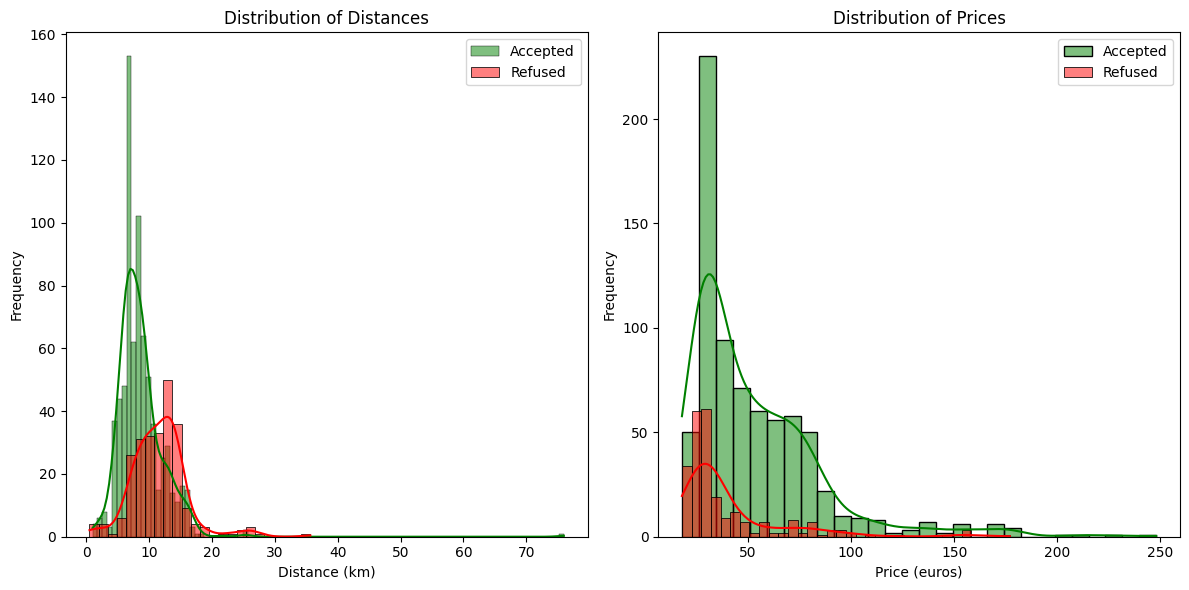

In [7]:
# Visualize the distribution of distance and price
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data[data['accepted'] == 1]['distance'], color='green', kde=True, label='Accepted')
sns.histplot(data[data['accepted'] == 0]['distance'], color='red', kde=True, label='Refused')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Distances')


plt.subplot(1, 2, 2)
sns.histplot(data[data['accepted'] == 1]['prix'], color='green', kde=True, label='Accepted')
sns.histplot(data[data['accepted'] == 0]['prix'], color='red', kde=True, label='Refused')
plt.xlabel('Price (euros)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Prices')

plt.tight_layout()
plt.show()

In [8]:
# From the previous graphs, we can see a great effect of distance on whether the proffesional will accept the job or not,
# the less is the distance, it is more likely to accept the offer. We can also see some overlapping
# when the distance is between ~[5-15] KM.

# For the price, the lesser the price is the less likely the professional will accept the job. Overlapping in prices ~[1-25]

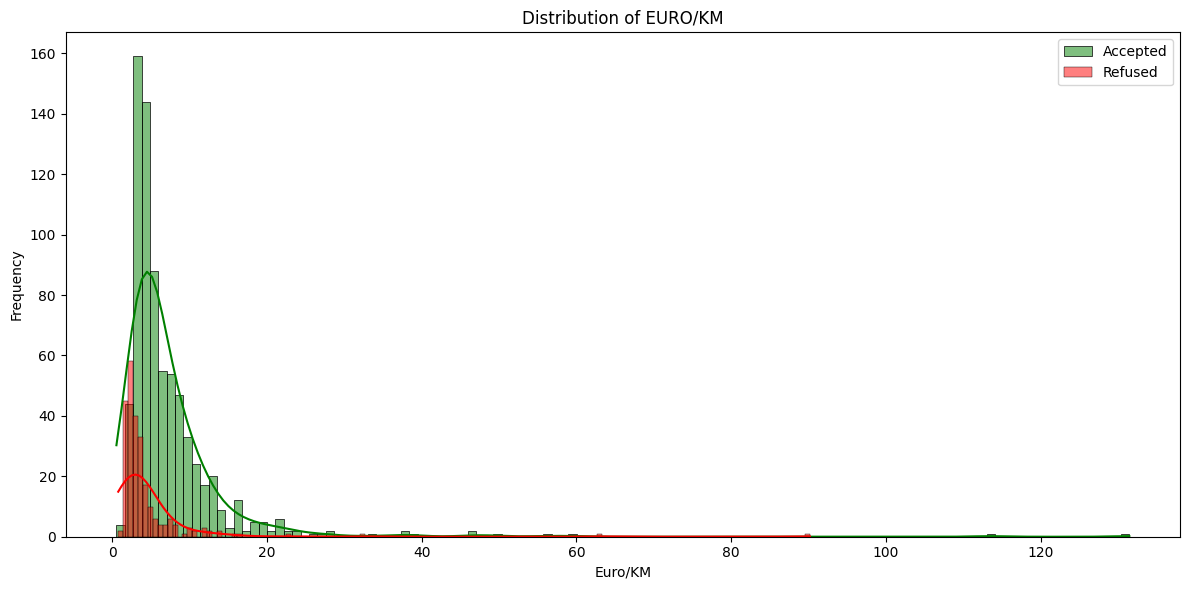

In [9]:
# Visualize the distribution of EURO/KM
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
sns.histplot(data[data['accepted'] == 1]['euro_per_km'], color='green', kde=True, label='Accepted')
sns.histplot(data[data['accepted'] == 0]['euro_per_km'], color='red', kde=True, label='Refused')
plt.xlabel('Euro/KM')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of EURO/KM')
plt.tight_layout()
plt.show()

In [10]:
# The previous graph is interesting, it shows that if Euro/KM is >= 5, it is very likely the professional will accept the jon.

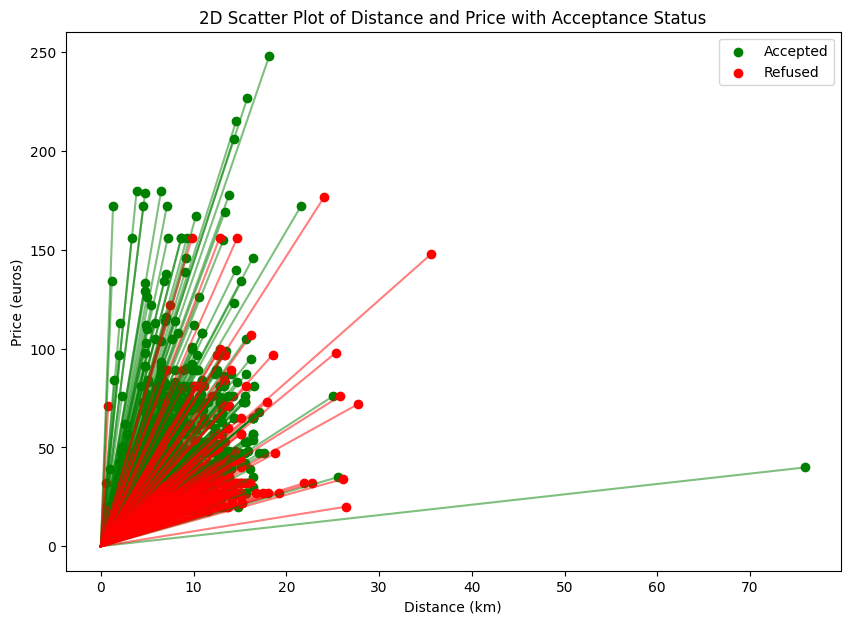

In [11]:
# Another way to visualize the data in term of the distance ot the original location.

# Create a 2D scatter plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot accepted proposals in green
accepted_proposals = data[data['accepted'] == 1]
ax.scatter(accepted_proposals['distance'], accepted_proposals['prix'], color='green', label='Accepted')

# Plot refused proposals in red
refused_proposals = data[data['accepted'] == 0]
ax.scatter(refused_proposals['distance'], refused_proposals['prix'], color='red', label='Refused')

# Plot lines connecting each point to the origin
for _, row in data.iterrows():
    if row['accepted'] == 1:
        ax.plot([0, row['distance']], [0, row['prix']], color='green', alpha=0.5)
    else:
        ax.plot([0, row['distance']], [0, row['prix']], color='red', alpha=0.5)

# Set labels
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Price (euros)')

# Set title
ax.set_title('2D Scatter Plot of Distance and Price with Acceptance Status')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# From the scatter plot, only one case could be an outlier, which has a price of ~40 euros and distance of ~75km,
# no further processing since we gonna use multiple ML methods that handles outliers.

DecisionTreeClassifier(class_weight={0: 3, 1: 1}, max_depth=3, random_state=42)
Distance weight: 0.31
Price weight: 0.00
Euro/KM weight: 0.69

Confusion Matrix:
[[ 32  17]
 [ 14 137]]
Accuracy: 0.84
Precision: 0.89
Recall: 0.91

Acceptance probability for a 100-euro proposal at 10 km: 0.78


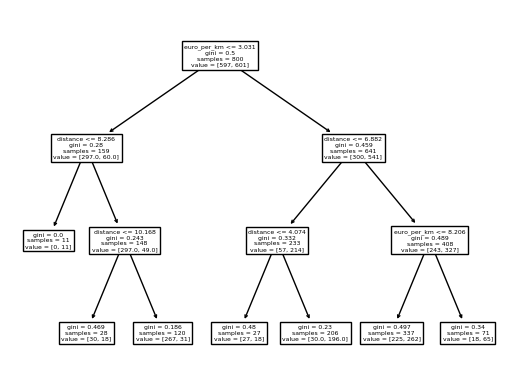

In [12]:
# Now that the dataset is clean and prepared, we can run different ML models and show the difference.

# Prepare data for modeling, we can drop latitude and longitude for easier understanding.
X = data[['distance', 'prix', 'euro_per_km']]

y = data['accepted']

# Split the data, 80% for training, 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model:
# The first model that always comes to my mind is the Decision Tree, easy to understand the results, works well in general
# and can handle categorical and continuous features, also it can easily be extended for ensemble methods.

# We mentioned before that the data is unbalanced, we can use class_weight in DecisionTreeClassifier
# to counter this problem. a 'class_weight'={0:3, 1:1} gives three times more importance for class 0 (refused jobs).
# The values of the weights are based on the distribution of the classes, ~75% class 1, ~25% class 0.

# And for better reassurance, we will use a grid search to find the best hyper-parameters for a variety of parameters.

param_grid = {'random_state': [42], 'max_depth': [3, 4, 5], 'class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}]}

# We will do 5 folds cross-valdation, and we will use precision as our scoring method since the dataset is unbalanced.
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)
tree_clf = grid_search.best_estimator_
print(tree_clf)

# Re-train on the full training data.
tree_clf.fit(X_train, y_train)

# If are using a tree based model, we can also visualize the tree.
# This line works if we are using a DecisionTreeClassifier.
tree.plot_tree(tree_clf, feature_names=['distance', 'prix', 'euro_per_km'])

# Let's see the feature importance.
print(f'Distance weight: {tree_clf.feature_importances_[0]:.2f}')
print(f'Price weight: {tree_clf.feature_importances_[1]:.2f}')
print(f'Euro/KM weight: {tree_clf.feature_importances_[2]:.2f}')
print()

# Evaluate the model on new cases.
tree_predictions = tree_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_predictions))
print(f"Accuracy: {accuracy_score(y_test, tree_predictions):.2f}")
print(f"Precision: {precision_score(y_test, tree_predictions):.2f}")
print(f"Recall: {recall_score(y_test, tree_predictions):.2f}")
print()
# Predict probability for a specific case
proposal = pd.DataFrame({'distance': [10], 'prix': [100], 'euro_per_km': [10]})
tree_acceptance_probability = tree_clf.predict_proba(proposal)[:, 1][0]

print(f"Acceptance probability for a 100-euro proposal at 10 km: {tree_acceptance_probability:.2f}")

# More classifier we can use that might give better results with GridSearch and fine tuning
# tree_clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=3)
# tree_clf = GradientBoostingClassifier(n_estimators=50, random_state=42, learning_rate=0.2)

In [13]:
# The previous results show that the best feature we have is the euro_per_km with ~0.7 weight.
# Accuracy is decent, precision for class 1 is high, for class 0 could be better, but seeing that the data is unbalanced,
# more date could be required for better results.

# With the grid search, we can see that using weights when training yielded a better model, which shows the effect of fine tuning our parameters.

In [14]:
# Another method we could use is Logistic Regression.

# Train the model.
# In Logistic Regression, it is always recommended to normalize the dataset so that the learned coefficients
# reflect the feature importance.

# The StandardScaler normalize the data with a mean of 0 and std of 1. 
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

# Once we normalize the data, we can also add weights to the features, imagine the case where we are more interested
# in price rather than distance, professional would go an extra 5 KM if the price is much higher.

# I didn't use the weights in this case, I just wanted to highlight the idea.

# Define custom weights for features
# weights = {'distance': 1, 'prix': 1, 'euro_per_km': 1}  
# scaled_X_train[:, 0] *= weights['distance']
# scaled_X_train[:, 1] *= weights['prix']
# scaled_X_train[:, 2] *= weights['euro_per_km']

# Same as before, let's try some GridSearch with class weights and different values of C (regularization strength).
param_grid = {'class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}], 'C': [0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='precision')
grid_search.fit(scaled_X_train, y_train)
lr_clf = grid_search.best_estimator_
print(lr_clf)

# Re-train on the full training data.
lr_clf.fit(scaled_X_train, y_train)

scaled_X_test = scaler.transform(X_test)
# scaled_X_test[:, 0] *= weights['distance']
# scaled_X_test[:, 1] *= weights['prix']
# scaled_X_test[:, 2] *= weights['euro_per_km']

# Evaluate the model
lr_predictions = lr_clf.predict(scaled_X_test)

print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.2f}")
print(f"Precision: {precision_score(y_test, lr_predictions):.2f}")
print(f"Recall: {recall_score(y_test, lr_predictions):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))
print()

# Predict probability for a specific case
proposal = pd.DataFrame({'distance': [10], 'prix': [100], 'euro_per_km': [10]})
proposal = scaler.transform(proposal)
# proposal[:, 0] *= weights['distance'] 
# proposal[:, 1] *= weights['prix']
# proposal[:, 2] *= weights['euro_per_km']
lr_acceptance_probability = lr_clf.predict_proba(proposal)[:, 1][0]
print(f"Acceptance probability for a 100-euro proposal at 10 km: {lr_acceptance_probability:.2f}")

LogisticRegression(C=1, class_weight={0: 3, 1: 1})
Accuracy: 0.78
Precision: 0.93
Recall: 0.76
Confusion Matrix:
[[ 41   8]
 [ 36 115]]

Acceptance probability for a 100-euro proposal at 10 km: 0.80


In [15]:
# The final method I wanted to highlight is the KNN.
# And as we have seen before, professionals tend to accept jobs that they accepted before, and KNN would capture that.

# We can also use differetn weights for the different features.

param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
# We will do 5 folds cross-valdation, and we will use precision as our scoring method since the dataset is unbalanced.
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='precision')
grid_search.fit(scaled_X_train, y_train)
knn_clf = grid_search.best_estimator_
print(knn_clf)

# Re-train on the full training data.
knn_clf.fit(scaled_X_train, y_train)

knn_predictions = knn_clf.predict(scaled_X_test)
print(f"Accuracy: {accuracy_score(y_test, knn_predictions):.2f}")
print(f"Precision: {precision_score(y_test, knn_predictions):.2f}")
print(f"Recall: {recall_score(y_test, knn_predictions):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn_predictions))
print()

# Predict probability for a specific case
proposal = pd.DataFrame({'distance': [10], 'prix': [100], 'euro_per_km': [10]})
proposal = scaler.transform(proposal)
knn_acceptance_probability = knn_clf.predict_proba(proposal)[:, 1][0]
print(f"Acceptance probability for a 100-euro proposal at 10 km: {knn_acceptance_probability:.2f}")
print()

# Showing off the nearest neighbors rows
print('Distance / Price / Euro_KM / Accepted')
for y_ind in knn_clf.kneighbors(proposal)[1][0]:
    print(round(X_train.values[y_ind][0], 2), round(X_train.values[y_ind][1], 2),
          round(X_train.values[y_ind][2], 2), y_train.values[y_ind])

KNeighborsClassifier(n_neighbors=3)
Accuracy: 0.82
Precision: 0.86
Recall: 0.92
Confusion Matrix:
[[ 26  23]
 [ 12 139]]

Acceptance probability for a 100-euro proposal at 10 km: 1.00

Distance / Price / Euro_KM / Accepted
9.82 100.0 10.19 1
9.82 101.0 10.29 1
10.39 97.0 9.34 1


In [16]:
# Finally, we can show the different acceptance probability of the three different methods:

print(f'Decision Tree: {tree_acceptance_probability:.2f}')
print(f'Logistice Regression: {lr_acceptance_probability:.2f}')
print(f'KNN: {knn_acceptance_probability:.2f}')

Decision Tree: 0.78
Logistice Regression: 0.80
KNN: 1.00


In [17]:
# From the results, the three different models recommend accepting this job, KNN gives 100% confidance rate,
# but it might be the slowest since we have to run the algorithm through all the dataset to find the nearest neighbors.

# Logistic Regression is second with 80% confidance rate, fast but not interpretable.

# And finally, Decision Tree with 78% confidance rate, fast and interpretable.

In [18]:
# Improvement:

# 1) In this file I only showed the general thoughts of how to approach this problem,
#    code refactoring, OOP, documentation and production value are implemented using '.py' files in the final folder.

# 2) From the graphs, we can see that there is some overlapping in feature values in term of accept/refuse decision,
#    if we can add more features like day and time of the job, the results could be improved,
#    for instance, did the professionals accept jobs on weekend? after 6pm? during rush hours ?

# 3) The data is unbalanced, so we can try balancing techniques such as running k-medoids to reduce the number of 'accept' jobs
#    and balance the data, but we should tread carefully since we might lose statistical information.

# 4) We can also use ensemble methods such as AdaBoost, GradientBoosting and RandomForest that might yield better results.

# 5) For production, a logging system can be used instead of verbose mode.

# 6) For production, a monitoring system that sends an alert when the quality of the results (i.e. precision), 
#    falls under a certain threshold (e.g. precision <= 0.7)